In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [215]:
def stock_trading_strategy(stock_price_df, start_date, end_date, initial_cash, investment, buy_threshold=0.05, sell_threshold=0.05, multiplier=1):
    # initialize variables
    num_shares = []
    total_cash = []
    num_shares_purchased = []
    num_shares_sold = []
    batches = []
    action = []
    action_date = []
    stock_price = []
    purchase_sell_action = []
    curr_cash = initial_cash
    # loop through each day in the dataframe
    stock_action_df = stock_price_df[stock_price_df['date'].between(start_date, end_date)]
    initial_price = stock_action_df.iloc[0]['daily_price']
    for i in range(len(stock_action_df)):
        # get the current price and date
        curr_price = stock_action_df.iloc[i]['daily_price']
        curr_date = stock_action_df.iloc[i]['date']
        action_date.append(curr_date)
        stock_price.append(curr_price)

        # check if we should purchase, sell, or pass
        if len(batches) == 0 or curr_price <= batches[-1][0] * (1-buy_threshold):
            if curr_price > initial_price:
                # pass
                action.append('Pass')
                num_shares_purchased.append(0)
                num_shares_sold.append(0)
                total_cash.append(total_cash[-1])
                num_shares.append(num_shares[-1])
            else:
                if len(purchase_sell_action) == 0:
                    pass
                elif purchase_sell_action[-1] == 'Purchase':
                    # increase investment amount at each purchase if the price keeps dropping
                    investment = investment * multiplier
                elif purchase_sell_action[-1] == 'Sell' and purchase_sell_action[-2] == 'Sell':
                    # reset investment amount as price begins to increase
                    investment = investment / multiplier
                else:
                    pass
                # purchase
                num_shares_to_purchase = min(curr_cash, investment) / curr_price
                if len(num_shares) == 0:
                    num_shares.append(num_shares_to_purchase)
                else:
                    num_shares.append(num_shares[-1] + num_shares_to_purchase)
                if len(total_cash) == 0:
                    total_cash.append(initial_cash - min(curr_cash, investment))
                else:
                    total_cash.append(total_cash[-1] - min(curr_cash, investment))
                batches.append((curr_price, num_shares_to_purchase))
                action.append('Purchase')
                purchase_sell_action.append('Purchase')
                num_shares_purchased.append(num_shares_to_purchase)
                num_shares_sold.append(0)
                curr_cash -= min(curr_cash, investment)
        elif curr_price >= batches[-1][0] * (1+sell_threshold):
            # sell
            num_shares_to_sell = batches[-1][1]
            num_shares.append(num_shares[-1] - num_shares_to_sell)
            total_cash.append(total_cash[-1] + num_shares_to_sell * curr_price)
            batches.pop()
            # this batch is sold
            action.append('Sell')
            purchase_sell_action.append('Sell')
            num_shares_purchased.append(0)
            num_shares_sold.append(num_shares_to_sell)
            curr_cash += num_shares_to_sell * curr_price
        else:
            # pass
            action.append('Pass')
            num_shares_purchased.append(0)
            num_shares_sold.append(0)
            total_cash.append(total_cash[-1])
            num_shares.append(num_shares[-1])

        
        # add the results to a new dataframe row
        results_df = pd.DataFrame({
            'date': action_date,
            'daily_price':stock_price,
            'action': action,
            'num_shares_purchased': num_shares_purchased,
            'purchase_value':np.array(stock_price)*np.array(num_shares_purchased),
            'num_shares_sold': num_shares_sold,
            'sell_value':np.array(stock_price)*np.array(num_shares_sold),
            'total_num_shares': num_shares,
            'total_stock_value':np.array(stock_price)*np.array(num_shares),
            'total_cash': total_cash
        })
        
        # concatenate the new row to the overall results dataframe
    return results_df

In [216]:
def plot_trading_strategy(df_stock, result):
    # plot the daily stock prices as a curve
    plt.figure(figsize=(16, 8))
    plt.plot(df_stock['date'], df_stock['daily_price'], label='Stock Price')


    # plot the purchase actions as red dots
    purchases = result[result['action'] == 'Purchase']
    plt.scatter(purchases['date'], purchases['daily_price'], color='red', label='Purchase')

    for index, row in purchases.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    # plot the sell actions as blue dots
    sells = result[result['action'] == 'Sell']
    plt.scatter(sells['date'], sells['daily_price'], color='blue', label='Sell')


    for index, row in sells.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Trading Strategy')
    plt.legend()

    plt.show()

In [252]:
df_google = pd.read_csv('~/Downloads/GOOGL.csv')
print(df_google.columns)
df_google_stock = df_google[['Date','Open']]
df_google_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_google_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,145.054993
1,2022-01-04,145.395996
2,2022-01-05,144.419998
3,2022-01-06,136.998505
4,2022-01-07,138.145493


In [253]:
result = stock_trading_strategy(df_google_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))

print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 623.2226171670645
Underlying stock price change: -9.83%
Max Profit ever: 667.0935965531789
Max Loss ever: -651.9023899724962
Number of Purchase & Sell actions: 27
Minimal Cash Reserved:  4241.944007443242


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,117.031502,Purchase,8.544708,1000.0,0.0,0.0,8.544708,1000.000000,9000.0
1,2022-05-05,120.204002,Pass,0.000000,0.0,0.0,0.0,8.544708,1027.108086,9000.0
2,2022-05-06,115.184502,Pass,0.000000,0.0,0.0,0.0,8.544708,984.217925,9000.0
3,2022-05-09,113.250000,Pass,0.000000,0.0,0.0,0.0,8.544708,967.688170,9000.0
4,2022-05-10,115.507500,Pass,0.000000,0.0,0.0,0.0,8.544708,986.977848,9000.0


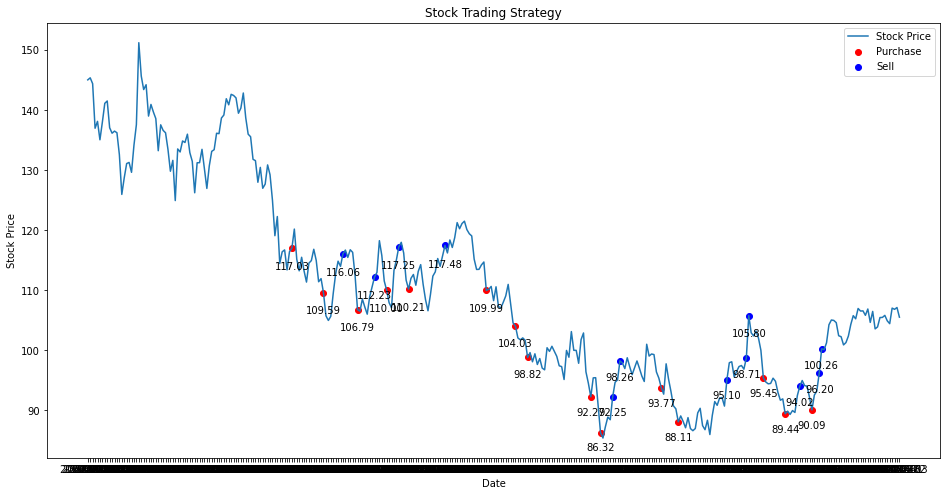

In [254]:
plot_trading_strategy(df_google_stock, result)

In [255]:
for sell_trigger in [0.05, 0.07, 0.1]:
    result = stock_trading_strategy(df_google_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=sell_trigger, multiplier=1.05)
    print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])

10755.890992214154
10755.528145660426
10679.701220518538


In [256]:
df_goos = pd.read_csv('~/Downloads/GOOS.csv')
print(df_goos.columns)
df_goos_stock = df_goos[['Date','Open']]
df_goos_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_goos_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,37.189999
1,2022-01-04,37.930000
2,2022-01-05,37.389999
3,2022-01-06,36.540001
4,2022-01-07,35.340000


In [257]:
result = stock_trading_strategy(df_goos_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))

print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 1675.450416537993
Underlying stock price change: -16.78%
Max Profit ever: 1753.519977532007
Max Loss ever: -457.9160646623368
Number of Purchase & Sell actions: 56
Minimal Cash Reserved:  4706.670194487837


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,22.639999,Purchase,44.169613,1000.0,0.0,0.0,44.169613,1000.000000,9000.0
1,2022-05-05,22.520000,Pass,0.000000,0.0,0.0,0.0,44.169613,994.699691,9000.0
2,2022-05-06,20.730000,Purchase,48.239267,1000.0,0.0,0.0,92.408880,1915.636083,8000.0
3,2022-05-09,19.490000,Purchase,51.308363,1000.0,0.0,0.0,143.717243,2801.049072,7000.0
4,2022-05-10,19.010000,Pass,0.000000,0.0,0.0,0.0,143.717243,2732.064795,7000.0


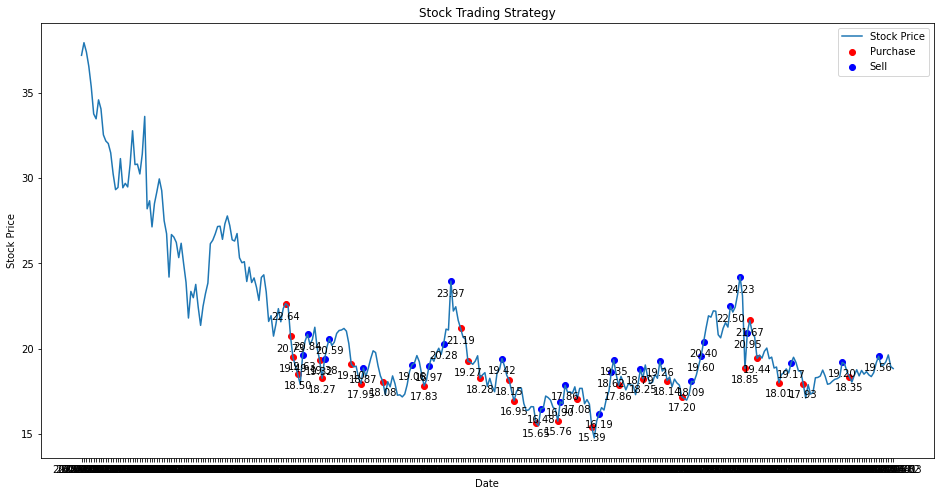

In [258]:
plot_trading_strategy(df_goos_stock, result)

In [259]:
df_BRK = pd.read_csv('~/Downloads/BRK-B.csv')
print(df_BRK.columns)
df_BRK_stock = df_BRK[['Date','Open']]
df_BRK_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_BRK_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,300.100006
1,2022-01-04,301.649994
2,2022-01-05,309.869995
3,2022-01-06,312.980011
4,2022-01-07,315.559998


In [367]:
result = stock_trading_strategy(df_BRK_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 429.64313799448246
Underlying stock price change: 2.52%
Max Profit ever: 439.10722117597834
Max Loss ever: -334.36267972820497
Number of Purchase & Sell actions: 15
Minimal Cash Reserved:  6057.831870709462


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,319.100006,Purchase,3.133814,1000.0,0.000000,0.000000,3.133814,1000.000000,9000.000000
26,2022-06-10,296.079987,Purchase,3.377466,1000.0,0.000000,0.000000,6.511279,1927.859547,8000.000000
29,2022-06-15,281.160004,Purchase,3.556694,1000.0,0.000000,0.000000,10.067973,2830.711368,7000.000000
59,2022-07-29,297.420013,Sell,0.000000,0.0,3.556694,1057.831871,6.511279,1936.584831,8057.831871
83,2022-09-01,279.950012,Purchase,3.572066,1000.0,0.000000,0.000000,10.083346,2822.832772,7057.831871
99,2022-09-26,265.820007,Purchase,3.761944,1000.0,0.000000,0.000000,13.845290,3680.355045,6057.831871
115,2022-10-18,282.739990,Sell,0.000000,0.0,3.761944,1063.652030,10.083346,2850.965084,7121.483900
124,2022-10-31,297.980011,Sell,0.000000,0.0,3.572066,1064.404352,6.511279,1940.231134,8185.888252
135,2022-11-15,313.670013,Sell,0.000000,0.0,3.377466,1059.409709,3.133814,982.983413,9245.297962
157,2022-12-16,299.049988,Purchase,3.343923,1000.0,0.000000,0.000000,6.477736,1937.166977,8245.297962


In [368]:
result = stock_trading_strategy(df_BRK_stock, '2022-06-10', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 296.69019564069094
Underlying stock price change: 10.49%
Max Profit ever: 296.69019564069094
Max Loss ever: -150.9718370467417
Number of Purchase & Sell actions: 10
Minimal Cash Reserved:  7057.831870709462


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-06-10,296.079987,Purchase,3.377466,1000.0,0.000000,0.000000,3.377466e+00,1.000000e+03,9000.000000
3,2022-06-15,281.160004,Purchase,3.556694,1000.0,0.000000,0.000000,6.934159e+00,1.949608e+03,8000.000000
33,2022-07-29,297.420013,Sell,0.000000,0.0,3.556694,1057.831871,3.377466e+00,1.004526e+03,9057.831871
57,2022-09-01,279.950012,Purchase,3.572066,1000.0,0.000000,0.000000,6.949532e+00,1.945522e+03,8057.831871
73,2022-09-26,265.820007,Purchase,3.761944,1000.0,0.000000,0.000000,1.071148e+01,2.847325e+03,7057.831871
89,2022-10-18,282.739990,Sell,0.000000,0.0,3.761944,1063.652030,6.949532e+00,1.964911e+03,8121.483900
98,2022-10-31,297.980011,Sell,0.000000,0.0,3.572066,1064.404352,3.377466e+00,1.006417e+03,9185.888252
109,2022-11-15,313.670013,Sell,0.000000,0.0,3.377466,1059.409709,-4.440892e-16,-1.392975e-13,10245.297962
193,2023-03-20,295.570007,Purchase,3.383293,1000.0,0.000000,0.000000,3.383293e+00,1.000000e+03,9245.297962
204,2023-04-04,310.760010,Sell,0.000000,0.0,3.383293,1051.392234,-4.440892e-16,-1.380052e-13,10296.690196


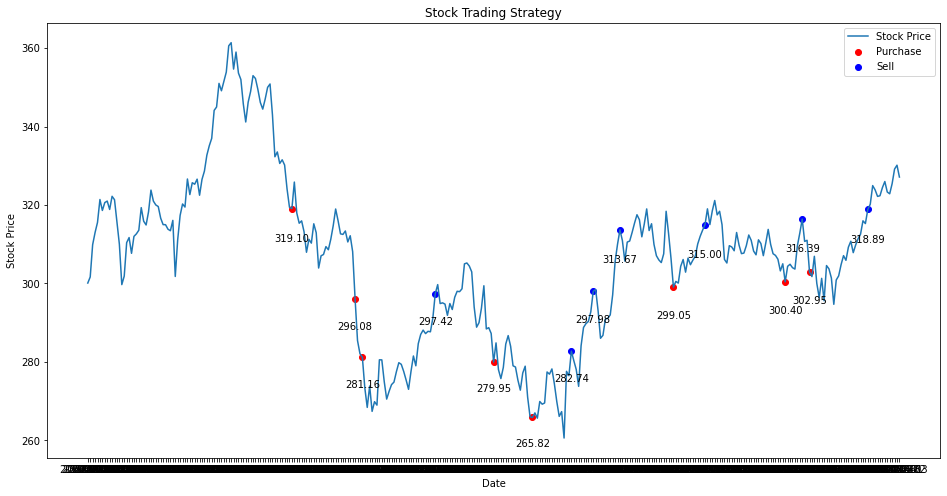

In [261]:
plot_trading_strategy(df_BRK_stock, result)

In [376]:
to_check = []
for e1 in [.03, .05]:
    for e2 in [.1, .12, .15, .3]:
        for m in [1,1.05, 1.1,1.2]:
            result = stock_trading_strategy(df_BRK_stock, '2022-06-10', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)))
for better in sorted(
    to_check, 
    key=lambda x: x[-1],
    reverse=True
)[:10]:
    print(better)

(0.03, 0.3, 1.2, 1004.5613641958826)
(0.03, 0.3, 1.1, 843.3503787934897)
(0.03, 0.15, 1.2, 808.2204656022204)
(0.03, 0.3, 1.05, 770.635874756219)
(0.03, 0.1, 1.2, 722.9829117875543)
(0.03, 0.3, 1, 702.9266379281617)
(0.03, 0.15, 1.1, 689.0374313916564)
(0.03, 0.12, 1.2, 661.3394576893716)
(0.03, 0.15, 1.05, 634.9350659185584)
(0.05, 0.3, 1.2, 631.934533345624)


In [377]:
to_check = []
for e1 in [.03, .05]:
    for e2 in [.1, .12, .15, .3]:
        for m in [1,1.05, 1.1,1.2]:
            result = stock_trading_strategy(df_BRK_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)))
for better in sorted(
    to_check, 
    key=lambda x: x[-1],
    reverse=True
)[:10]:
    print(better)

(0.03, 0.3, 1.2, 1546.4722616204272)
(0.03, 0.15, 1.2, 1263.7413676455526)
(0.03, 0.1, 1.2, 1140.9992901524365)
(0.03, 0.3, 1.1, 1114.1295742219663)
(0.03, 0.12, 1.2, 1052.2327162510537)
(0.03, 0.3, 1.05, 940.1875271523222)
(0.03, 0.15, 1.1, 927.4109078657493)
(0.03, 0.1, 1.1, 845.1957840846298)
(0.03, 0.15, 1.05, 790.5773854088002)
(0.03, 0.3, 1, 790.3739725134965)


In [379]:
result = stock_trading_strategy(df_BRK_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.03, sell_threshold=0.3, multiplier=1.2)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 1546.4722616204272
Underlying stock price change: 2.52%
Max Profit ever: 1652.4196765931956
Max Loss ever: -788.2390149740258
Number of Purchase & Sell actions: 6
Minimal Cash Reserved:  70.08000000000038


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,319.100006,Purchase,3.133814,1000.00,0,0.0,3.133814,1000.000000,9000.00
6,2022-05-12,307.950012,Purchase,3.896736,1200.00,0,0.0,7.030550,2165.057995,7800.00
26,2022-06-10,296.079987,Purchase,4.863551,1440.00,0,0.0,11.894101,3521.605189,6360.00
27,2022-06-13,285.429993,Purchase,6.054024,1728.00,0,0.0,17.948125,5122.933088,4632.00
30,2022-06-16,273.390015,Purchase,7.584769,2073.60,0,0.0,25.532893,6980.438062,2558.40
112,2022-10-13,260.579987,Purchase,9.549160,2488.32,0,0.0,35.082053,9141.680985,70.08


In [381]:
result = stock_trading_strategy(df_BRK_stock, '2022-06-10', '2023-05-03',10000, 1000, buy_threshold=0.03, sell_threshold=0.3, multiplier=1.2)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 1004.5613641958826
Underlying stock price change: 10.49%
Max Profit ever: 1063.391385678311
Max Loss ever: -291.84699642924534
Number of Purchase & Sell actions: 4
Minimal Cash Reserved:  4632.0


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-06-10,296.079987,Purchase,3.377466,1000.0,0,0.0,3.377466,1000.000000,9000.0
1,2022-06-13,285.429993,Purchase,4.204183,1200.0,0,0.0,7.581649,2164.030011,7800.0
4,2022-06-16,273.390015,Purchase,5.267200,1440.0,0,0.0,12.848849,3512.747124,6360.0
86,2022-10-13,260.579987,Purchase,6.631361,1728.0,0,0.0,19.480211,5076.153004,4632.0


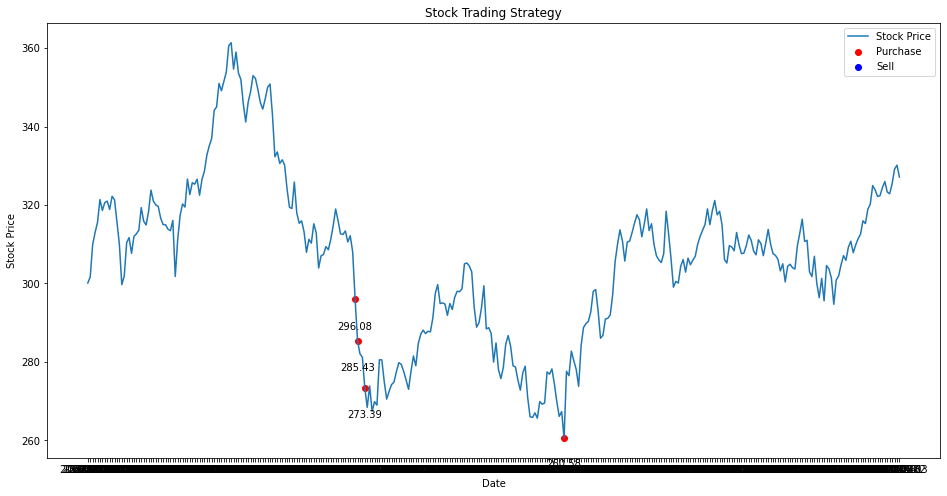

In [382]:
plot_trading_strategy(df_BRK_stock, result)

In [262]:
df_BABA = pd.read_csv('~/Downloads/BABA.csv')
print(df_BABA.columns)
df_BABA_stock = df_BABA[['Date','Open']]
df_BABA_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_BABA_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,119.379997
1,2022-01-04,119.529999
2,2022-01-05,118.000000
3,2022-01-06,124.260002
4,2022-01-07,130.240005


In [263]:
result = stock_trading_strategy(df_BABA_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 1621.3153858464466
Underlying stock price change: -16.80%
Max Profit ever: 1949.3547433354688
Max Loss ever: -291.9619841780295
Number of Purchase & Sell actions: 49
Minimal Cash Reserved:  4900.122771106297


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,97.720001,Purchase,10.233320,1000.0,0.0,0.0,10.233320,1000.000000,9000.0
1,2022-05-05,97.940002,Pass,0.000000,0.0,0.0,0.0,10.233320,1002.251341,9000.0
2,2022-05-06,93.360001,Pass,0.000000,0.0,0.0,0.0,10.233320,955.382727,9000.0
3,2022-05-09,86.955002,Purchase,11.500201,1000.0,0.0,0.0,21.733521,1889.838325,8000.0
4,2022-05-10,88.639999,Pass,0.000000,0.0,0.0,0.0,21.733521,1926.459242,8000.0


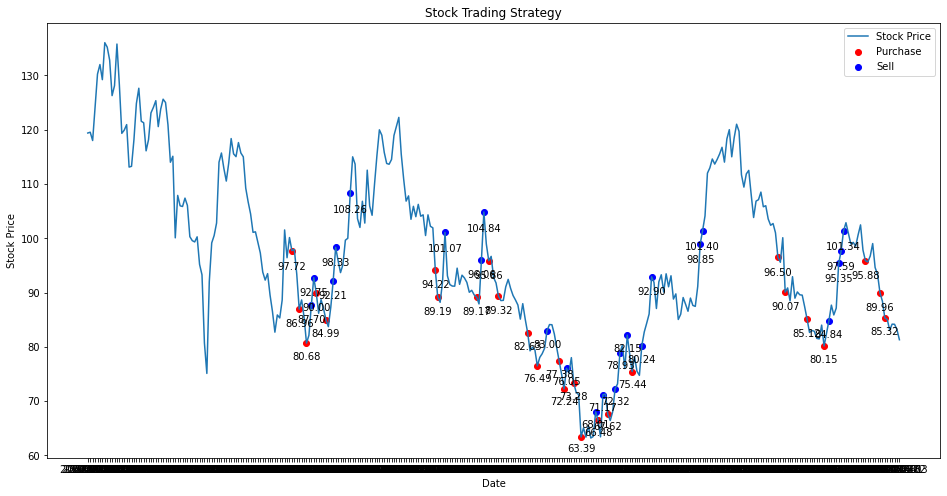

In [264]:
plot_trading_strategy(df_BABA_stock, result)

In [265]:
result[result['action'].isin(['Purchase','Sell'])].head(20)

,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,97.720001,Purchase,10.233320,1000.0,0.000000,0.000000,1.023332e+01,1.000000e+03,9000.000000
3,2022-05-09,86.955002,Purchase,11.500201,1000.0,0.000000,0.000000,2.173352e+01,1.889838e+03,8000.000000
6,2022-05-12,80.680000,Purchase,12.394646,1000.0,0.000000,0.000000,3.412817e+01,2.753460e+03,7000.000000
8,2022-05-16,87.699997,Sell,0.000000,0.0,12.394646,1087.010374,2.173352e+01,1.906030e+03,8087.010374
9,2022-05-17,92.750000,Sell,0.000000,0.0,11.500201,1066.643642,1.023332e+01,9.491404e+02,9153.654016
10,2022-05-18,90.000000,Purchase,11.111111,1000.0,0.000000,0.000000,2.134443e+01,1.920999e+03,8153.654016
14,2022-05-24,84.989998,Purchase,11.766090,1000.0,0.000000,0.000000,3.311052e+01,2.814063e+03,7153.654016
17,2022-05-27,92.209999,Sell,0.000000,0.0,11.766090,1084.951184,2.134443e+01,1.968170e+03,8238.605201
18,2022-05-31,98.330002,Sell,0.000000,0.0,11.111111,1092.555578,1.023332e+01,1.006242e+03,9331.160778
24,2022-06-08,108.260002,Sell,0.000000,0.0,10.233320,1107.859199,3.552714e-15,3.846168e-13,10439.019977


In [266]:
df_COF = pd.read_csv('~/Downloads/COF.csv')
print(df_COF.columns)
df_COF_stock = df_COF[['Date','Open']]
df_COF_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_COF_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,146.080002
1,2022-01-04,150.429993
2,2022-01-05,152.229996
3,2022-01-06,149.070007
4,2022-01-07,150.630005


In [267]:
result = stock_trading_strategy(df_COF_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 392.50380587157633
Underlying stock price change: -30.17%
Max Profit ever: 1055.660397817046
Max Loss ever: -374.1243017299694
Number of Purchase & Sell actions: 41
Minimal Cash Reserved:  4626.161351058823


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,128.720001,Purchase,7.7688,1000.0,0.0,0.0,7.7688,1000.000000,9000.0
1,2022-05-05,132.000000,Pass,0.0000,0.0,0.0,0.0,7.7688,1025.481658,9000.0
2,2022-05-06,129.850006,Pass,0.0000,0.0,0.0,0.0,7.7688,1008.778783,9000.0
3,2022-05-09,124.779999,Pass,0.0000,0.0,0.0,0.0,7.7688,969.390911,9000.0
4,2022-05-10,123.870003,Pass,0.0000,0.0,0.0,0.0,7.7688,962.321333,9000.0


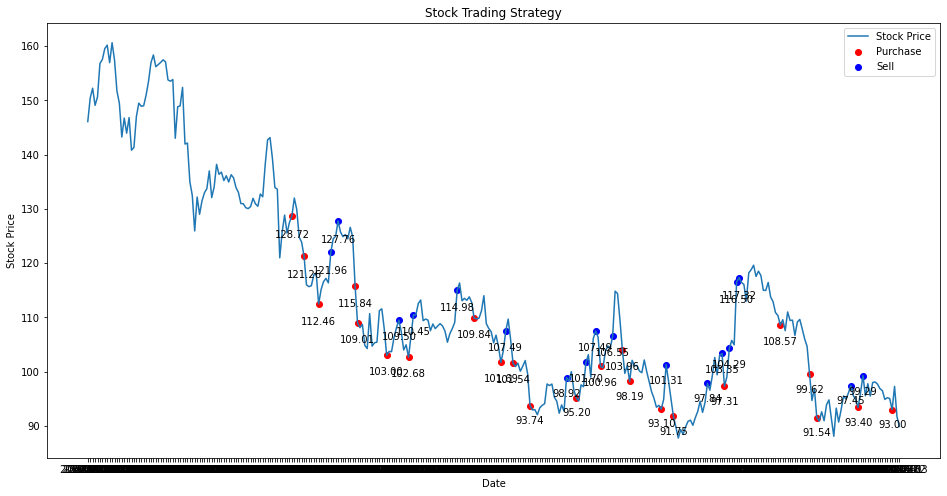

In [268]:
plot_trading_strategy(df_COF_stock, result)

In [269]:
df_AAPL = pd.read_csv('~/Downloads/AAPL.csv')
print(df_AAPL.columns)
df_AAPL_stock = df_AAPL[['Date','Open']]
df_AAPL_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_AAPL_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,177.830002
1,2022-01-04,182.630005
2,2022-01-05,179.610001
3,2022-01-06,172.699997
4,2022-01-07,172.889999


In [274]:
result = stock_trading_strategy(df_AAPL_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 729.4882201172986
Underlying stock price change: 6.16%
Max Profit ever: 729.4882201172986
Max Loss ever: -295.40967560135323
Number of Purchase & Sell actions: 26
Minimal Cash Reserved:  6438.4085177720735


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,159.669998,Purchase,6.262917,1000.0,0.0,0.0,6.262917,1000.000000,9000.0
1,2022-05-05,163.850006,Pass,0.000000,0.0,0.0,0.0,6.262917,1026.179045,9000.0
2,2022-05-06,156.009995,Pass,0.000000,0.0,0.0,0.0,6.262917,977.077704,9000.0
3,2022-05-09,154.929993,Pass,0.000000,0.0,0.0,0.0,6.262917,970.313740,9000.0
4,2022-05-10,155.520004,Pass,0.000000,0.0,0.0,0.0,6.262917,974.008931,9000.0


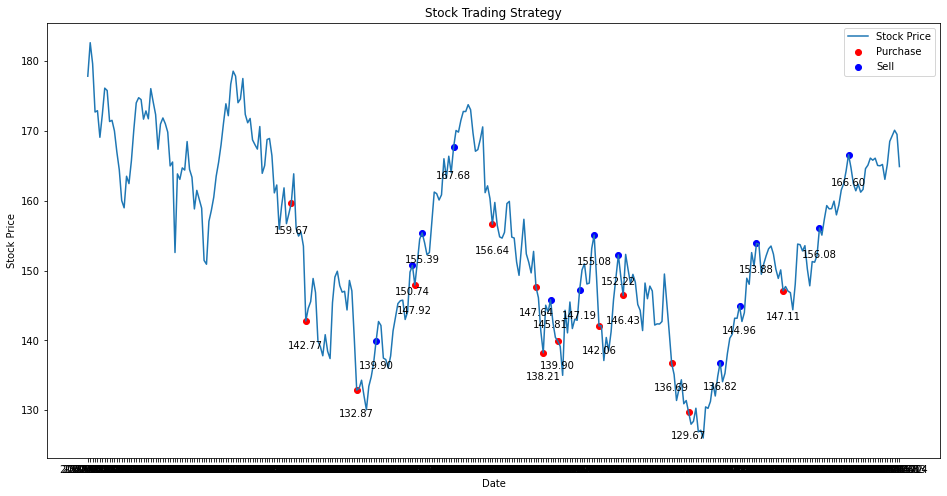

In [276]:
plot_trading_strategy(df_AAPL_stock, result)

In [277]:
df_SWPPX = pd.read_csv('~/Downloads/SWPPX.csv')
print(df_SWPPX.columns)
df_SWPPX_stock = df_SWPPX[['Date','Open']]
df_SWPPX_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_SWPPX_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,73.410004
1,2022-01-04,73.370003
2,2022-01-05,71.949997
3,2022-01-06,71.889999
4,2022-01-07,71.610001


In [345]:
result = stock_trading_strategy(df_SWPPX_stock, '2022-05-20', '2023-05-03',10000, 1000, buy_threshold=0.03, sell_threshold=0.07, multiplier=1.05)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 438.5454492202243
Underlying stock price change: 4.81%
Max Profit ever: 458.562129453474
Max Loss ever: 0.0
Number of Purchase & Sell actions: 11
Minimal Cash Reserved:  6993.706756636559


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-20,60.049999,Purchase,16.65279,1000.0,0.0,0.0,16.65279,1000.000000,9000.0
1,2022-05-23,61.169998,Pass,0.00000,0.0,0.0,0.0,16.65279,1018.651108,9000.0
2,2022-05-24,60.680000,Pass,0.00000,0.0,0.0,0.0,16.65279,1010.491274,9000.0
3,2022-05-25,61.250000,Pass,0.00000,0.0,0.0,0.0,16.65279,1019.983364,9000.0
4,2022-05-26,62.470001,Pass,0.00000,0.0,0.0,0.0,16.65279,1040.299784,9000.0


In [346]:
to_check = []
for e1 in [.03, .05, .07, .1, .12, .15]:
    for e2 in [.03, .05, .07, .1, .12, .15]:
        for m in [1,1.05]:
            result = stock_trading_strategy(df_SWPPX_stock, '2022-05-20', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)))
for better in sorted(
    to_check, 
    key=lambda x: x[-1],
    reverse=True
)[:10]:
    print(better)


(0.03, 0.1, 1.05, 603.3985018914555)
(0.03, 0.1, 1, 576.4935115523585)
(0.03, 0.05, 1.05, 480.110049733903)
(0.03, 0.05, 1, 467.67218071329626)
(0.03, 0.07, 1.05, 438.5454492202243)
(0.03, 0.07, 1, 423.038885634749)
(0.03, 0.15, 1.05, 421.5520895284317)
(0.07, 0.05, 1.05, 405.40592963901327)
(0.03, 0.12, 1.05, 402.70358076944467)
(0.07, 0.05, 1, 399.619950485936)


Final Profit: 603.3985018914555
Underlying stock price change: 4.81%
Max Profit ever: 623.4151821247051
Max Loss ever: -81.33329233571203
Number of Purchase & Sell actions: 11
Minimal Cash Reserved:  7057.419731642618


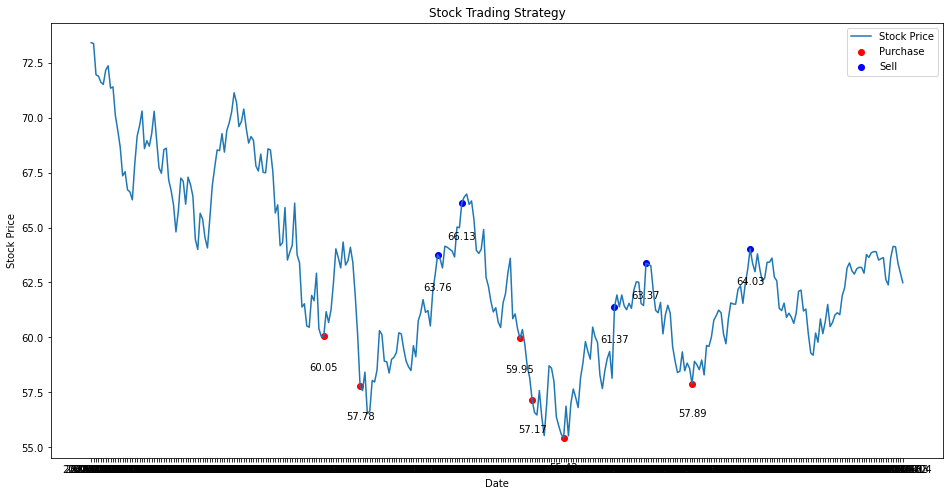

In [347]:
result = stock_trading_strategy(df_SWPPX_stock, '2022-05-20', '2023-05-03',10000, 1000, buy_threshold=0.03, sell_threshold=0.1, multiplier=1.05)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
plot_trading_strategy(df_SWPPX_stock, result)

In [288]:
df_YINN = pd.read_csv('~/Downloads/YINN.csv')
print(df_YINN.columns)
df_YINN_stock = df_YINN[['Date','Open']]
df_YINN_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_YINN_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,165.199997
1,2022-01-04,162.199997
2,2022-01-05,151.199997
3,2022-01-06,152.800003
4,2022-01-07,163.800003


In [313]:
result = stock_trading_strategy(df_YINN_stock, '2022-05-04', '2023-05-03',100, 10, buy_threshold=0.1, sell_threshold=0.1, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-100))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 100)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 100)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 16.630954132807773
Underlying stock price change: -52.47%
Max Profit ever: 28.54446000307371
Max Loss ever: -33.469976680772504
Number of Purchase & Sell actions: 47
Minimal Cash Reserved:  19.1639057290476


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,79.599998,Purchase,0.125628,10.0,0.0,0.0,0.125628,10.000000,90.0
1,2022-05-05,78.199997,Pass,0.000000,0.0,0.0,0.0,0.125628,9.824120,90.0
2,2022-05-06,69.400002,Purchase,0.144092,10.0,0.0,0.0,0.269720,18.718593,80.0
3,2022-05-09,61.799999,Purchase,0.161812,10.0,0.0,0.0,0.431533,26.668718,70.0
4,2022-05-10,63.400002,Pass,0.000000,0.0,0.0,0.0,0.431533,27.359171,70.0


In [405]:
to_check = []
for e1 in [.03,.05, .07, .1,.12,.15]:
    for e2 in [.03,.05, .07, .1,.12,.15]:
        for m in [1,1.05]:
            result = stock_trading_strategy(df_YINN_stock, '2022-9-29', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000), (result['total_stock_value']+result['total_cash']).min() - 10000))
for better in sorted(
    to_check, 
    key=lambda x: x[3],
    reverse=True
)[:10]:
    print(better)

(0.03, 0.03, 1.05, 400.07474275021923, -131.2634128237878)
(0.03, 0.03, 1, 356.06572353208685, -122.29480750377661)
(0.1, 0.1, 1.05, 268.54542231123924, -112.30234155975268)
(0.03, 0.15, 1.05, 257.0165580895591, -150.26019500597613)
(0.1, 0.1, 1, 242.97045392436848, -109.98541820109494)
(0.1, 0.03, 1.05, 226.43210740735958, -81.84451503805212)
(0.03, 0.15, 1, 221.1089456274567, -139.07829394469445)
(0.1, 0.03, 1, 206.62798286005273, -80.97796437090437)
(0.12, 0.15, 1.05, 194.61540314648846, 0.0)
(0.12, 0.15, 1, 182.64812696860463, 0.0)


In [403]:
result = stock_trading_strategy(df_YINN_stock, '2022-10-21', '2023-05-03',100, 10, buy_threshold=0.03, sell_threshold=0.1, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-100))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 100)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 100)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 16.454358154606155
Underlying stock price change: 25.76%
Max Profit ever: 16.45435815460617
Max Loss ever: -5.418514774983521
Number of Purchase & Sell actions: 12
Minimal Cash Reserved:  60.0


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-10-21,30.080000,Purchase,0.332447,10.0,0.0,0.0,0.332447,10.000000,90.0
1,2022-10-24,22.889999,Purchase,0.436872,10.0,0.0,0.0,0.769319,17.609707,80.0
2,2022-10-25,23.420000,Pass,0.000000,0.0,0.0,0.0,0.769319,18.017447,80.0
3,2022-10-26,23.290001,Pass,0.000000,0.0,0.0,0.0,0.769319,17.917436,80.0
4,2022-10-27,24.200001,Pass,0.000000,0.0,0.0,0.0,0.769319,18.617516,80.0


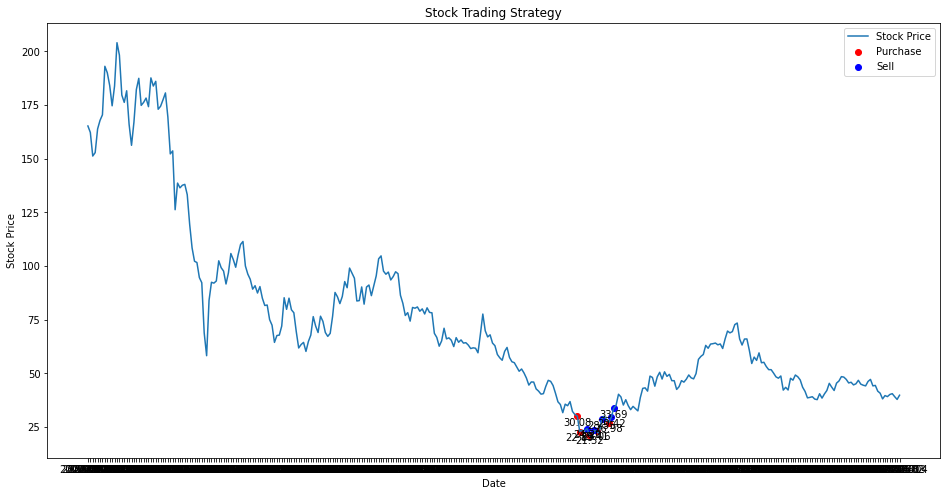

In [404]:
plot_trading_strategy(df_YINN_stock,
                      stock_trading_strategy(df_YINN_stock, '2022-10-21', '2023-05-03',100, 10, buy_threshold=0.07, sell_threshold=0.05, multiplier=1))

In [296]:
df_BITO = pd.read_csv('~/Downloads/BITO.csv')
print(df_BITO.columns)
df_BITO_stock = df_BITO[['Date','Open']]
df_BITO_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_BITO_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,29.750000
1,2022-01-04,29.670000
2,2022-01-05,29.260000
3,2022-01-06,27.000000
4,2022-01-07,26.379999


In [302]:
result = stock_trading_strategy(df_BITO_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 1211.2098297262492
Underlying stock price change: -32.91%
Max Profit ever: 1569.4902682717475
Max Loss ever: -2062.758456057094
Number of Purchase & Sell actions: 58
Minimal Cash Reserved:  1994.3100886596903


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,24.340000,Purchase,41.084634,1000.0,0.0,0.0,41.084634,1000.000000,9000.0
1,2022-05-05,24.570000,Pass,0.000000,0.0,0.0,0.0,41.084634,1009.449466,9000.0
2,2022-05-06,22.360001,Purchase,44.722717,1000.0,0.0,0.0,85.807351,1918.652465,8000.0
3,2022-05-09,20.360001,Purchase,49.115911,1000.0,0.0,0.0,134.923263,2747.037762,7000.0
4,2022-05-10,19.980000,Pass,0.000000,0.0,0.0,0.0,134.923263,2695.766787,7000.0


In [330]:
for e1 in [.05, .07, .1, .15]:
    for e2 in [.05, .07, .1, .15]:
        result = stock_trading_strategy(df_BITO_stock, '2022-05-04', '2023-05-03',200, 20, buy_threshold=e1, sell_threshold=e2, multiplier=1)
        print(e1, e2, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-200))

0.05 0.05 24.22419659452504
0.05 0.07 18.73510852024347
0.05 0.1 19.682695173206326
0.05 0.15 22.80299696194959
0.07 0.05 16.126270396209293
0.07 0.07 14.804311505399255
0.07 0.1 16.00093410324186
0.07 0.15 15.64900702957749
0.1 0.05 12.27147731468915
0.1 0.07 14.131728258661894
0.1 0.1 11.509518656994999
0.1 0.15 17.954097376019405
0.15 0.05 4.237896430230961
0.15 0.07 10.139054899877664
0.15 0.1 7.556588221796119
0.15 0.15 9.09757540560281


41.26094709298525


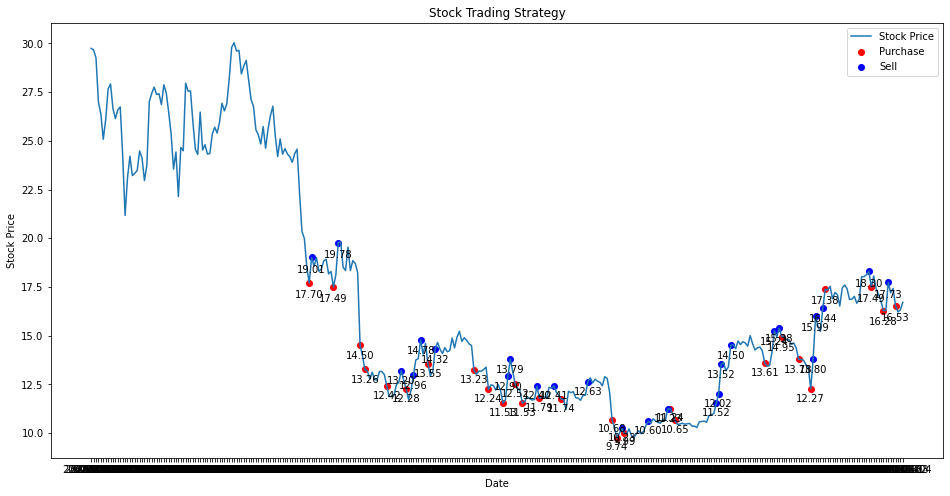

In [331]:
result = stock_trading_strategy(df_BITO_stock, '2022-05-12', '2023-05-03',200, 20, buy_threshold=.05, sell_threshold=.05, multiplier=1)
print((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-200)
plot_trading_strategy(df_BITO_stock, result)

In [304]:
df_BKCH = pd.read_csv('~/Downloads/BKCH.csv')
print(df_BKCH.columns)
df_BKCH_stock = df_BKCH[['Date','Open']]
df_BKCH_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_BKCH_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,88.879997
1,2022-01-04,88.919998
2,2022-01-05,87.879997
3,2022-01-06,80.440002
4,2022-01-07,78.199997


In [310]:
result = stock_trading_strategy(df_BKCH_stock, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.1, sell_threshold=0.1, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 830.3191289896931
Underlying stock price change: -52.56%
Max Profit ever: 1463.619110287531
Max Loss ever: -3519.2015992233382
Number of Purchase & Sell actions: 44
Minimal Cash Reserved:  1232.9485846792468


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,47.599998,Purchase,21.008404,1000.0,0.0,0.0,21.008404,1000.000000,9000.0
1,2022-05-05,48.560001,Pass,0.000000,0.0,0.0,0.0,21.008404,1020.168131,9000.0
2,2022-05-06,44.200001,Pass,0.000000,0.0,0.0,0.0,21.008404,928.571489,9000.0
3,2022-05-09,40.520000,Purchase,24.679171,1000.0,0.0,0.0,45.687575,1851.260540,8000.0
4,2022-05-10,37.919998,Pass,0.000000,0.0,0.0,0.0,45.687575,1732.472754,8000.0


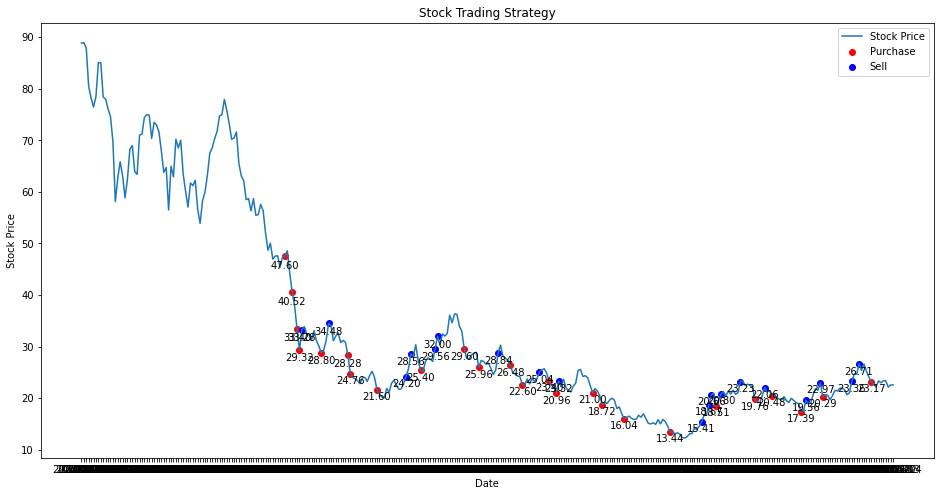

In [311]:
plot_trading_strategy(df_BKCH_stock, result)

In [348]:
df_QQQM = pd.read_csv('~/Downloads/QQQM.csv')
print(df_QQQM.columns)
df_QQQM_stock = df_QQQM[['Date','Open']]
df_QQQM_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_QQQM_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,164.110001
1,2022-01-04,165.399994
2,2022-01-05,162.449997
3,2022-01-06,157.225006
4,2022-01-07,157.854996


In [356]:
result = stock_trading_strategy(df_QQQM_stock, '2022-05-11', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 488.90624026775913
Underlying stock price change: 7.13%
Max Profit ever: 488.90624026775913
Max Loss ever: -115.34027456530202
Number of Purchase & Sell actions: 18
Minimal Cash Reserved:  7163.667474241571


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-11,122.760002,Purchase,8.145976,1000.0,0.000000,0.000000,8.145976e+00,1.000000e+03,9000.000000
22,2022-06-13,115.070000,Purchase,8.690362,1000.0,0.000000,0.000000,1.683634e+01,1.937357e+03,8000.000000
31,2022-06-27,121.779999,Sell,0.000000,0.0,8.690362,1058.312323,8.145976e+00,9.920169e+02,9058.312323
33,2022-06-29,116.589996,Purchase,8.577065,1000.0,0.000000,0.000000,1.672304e+01,1.949739e+03,8058.312323
47,2022-07-20,122.889999,Sell,0.000000,0.0,8.577065,1054.035537,8.145976e+00,1.001059e+03,9112.347860
55,2022-08-01,129.059998,Sell,0.000000,0.0,8.145976,1051.319615,1.776357e-15,2.292566e-13,10163.667474
78,2022-09-01,122.029999,Purchase,8.194706,1000.0,0.000000,0.000000,8.194706e+00,1.000000e+03,9163.667474
93,2022-09-23,114.180000,Purchase,8.758101,1000.0,0.000000,0.000000,1.695281e+01,1.935672e+03,8163.667474
106,2022-10-12,108.430000,Purchase,9.222540,1000.0,0.000000,0.000000,2.617535e+01,2.838193e+03,7163.667474
115,2022-10-25,114.970001,Sell,0.000000,0.0,9.222540,1060.315420,1.695281e+01,1.949064e+03,8223.982894


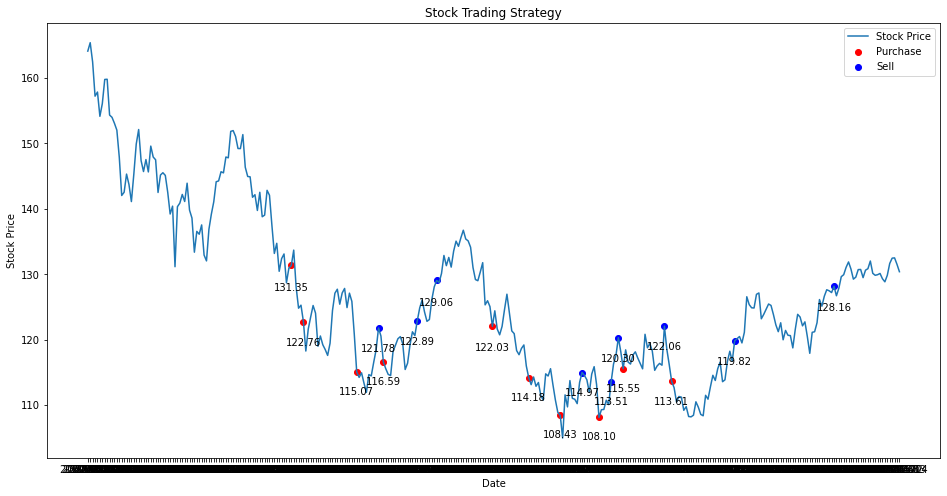

In [350]:
plot_trading_strategy(df_QQQM_stock, result)

In [357]:
to_check = []
for e1 in [.03, .05, .07, .1, .12, .15]:
    for e2 in [.03, .05, .07, .1, .12, .15]:
        for m in [1,1.05]:
            result = stock_trading_strategy(df_QQQM_stock, '2022-05-11', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000)))
for better in sorted(
    to_check, 
    key=lambda x: x[-1],
    reverse=True
)[:10]:
    print(better)


(0.03, 0.1, 1.05, 1086.313854119644)
(0.03, 0.15, 1.05, 1074.554827900094)
(0.03, 0.12, 1.05, 1041.518680509218)
(0.03, 0.15, 1, 970.4187831850031)
(0.03, 0.03, 1.05, 962.2492299079386)
(0.03, 0.1, 1, 955.4610771893585)
(0.03, 0.12, 1, 936.8326408390913)
(0.03, 0.03, 1, 898.4638642923292)
(0.03, 0.05, 1.05, 888.4941114159465)
(0.03, 0.07, 1.05, 877.1617175681167)


In [358]:
result = stock_trading_strategy(df_QQQM_stock, '2022-05-11', '2023-05-03',10000, 1000, buy_threshold=0.03, sell_threshold=0.1, multiplier=1.05)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 1086.313854119644
Underlying stock price change: 7.13%
Max Profit ever: 1094.8322943271214
Max Loss ever: -166.35523222061965
Number of Purchase & Sell actions: 17
Minimal Cash Reserved:  4517.762611855274


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-11,122.760002,Purchase,8.145976,1000.000000,0.000000,0.000000,8.145976e+00,1.000000e+03,9000.000000
1,2022-05-12,118.260002,Purchase,8.878742,1050.000000,0.000000,0.000000,1.702472e+01,2.013343e+03,7950.000000
23,2022-06-14,114.230003,Purchase,9.651580,1102.500000,0.000000,0.000000,2.667630e+01,3.047234e+03,6847.500000
49,2022-07-22,126.059998,Sell,0.000000,0.000000,9.651580,1216.678142,1.702472e+01,2.146136e+03,8064.178142
57,2022-08-03,130.119995,Sell,0.000000,0.000000,8.878742,1155.301813,8.145976e+00,1.059954e+03,9219.479955
63,2022-08-11,135.059998,Sell,0.000000,0.000000,8.145976,1100.195469,-1.776357e-15,-2.399148e-13,10319.675424
78,2022-09-01,122.029999,Purchase,8.604442,1050.000000,0.000000,0.000000,8.604442e+00,1.050000e+03,9269.675424
88,2022-09-16,118.330002,Purchase,9.317164,1102.500000,0.000000,0.000000,1.792161e+01,2.120664e+03,8167.175424
93,2022-09-23,114.180000,Purchase,10.138597,1157.625000,0.000000,0.000000,2.806020e+01,3.203914e+03,7009.550424
105,2022-10-11,108.889999,Purchase,11.162699,1215.506250,0.000000,0.000000,3.922290e+01,4.270982e+03,5794.044174


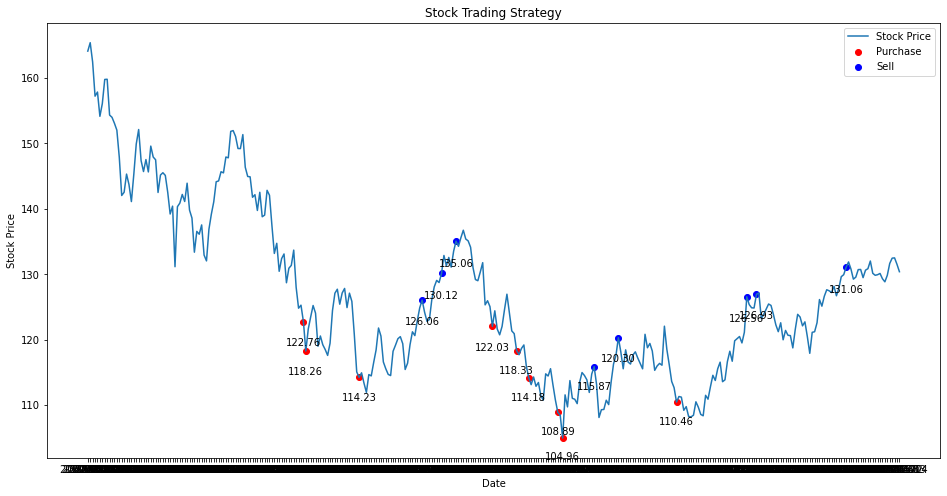

In [359]:
plot_trading_strategy(df_QQQM_stock, result)

In [383]:
df_TSLA = pd.read_csv('~/Downloads/TSLA.csv')
print(df_TSLA.columns)
df_TSLA_stock = df_TSLA[['Date','Open']]
df_TSLA_stock.rename(columns={"Date": "date", "Open": "daily_price"}, inplace=True)
df_TSLA_stock.head()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


/Users/yuchen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,daily_price
0,2022-01-03,382.583344
1,2022-01-04,396.516663
2,2022-01-05,382.216675
3,2022-01-06,359.000000
4,2022-01-07,360.123322


In [388]:
result = stock_trading_strategy(df_TSLA_stock, '2022-11-22', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result[result['action'].isin(['Purchase','Sell'])]

Final Profit: 1068.3910128940224
Underlying stock price change: -5.11%
Max Profit ever: 1087.4077008523382
Max Loss ever: -1066.5478516409494
Number of Purchase & Sell actions: 27
Minimal Cash Reserved:  3188.4154495891653


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-11-22,168.630005,Purchase,5.930143,1000.0,0.000000,0.000000,5.930143e+00,1.000000e+03,9000.000000
2,2022-11-25,185.059998,Sell,0.000000,0.0,5.930143,1097.432204,0.000000e+00,0.000000e+00,10097.432204
15,2022-12-14,159.250000,Purchase,6.279435,1000.0,0.000000,0.000000,6.279435e+00,1.000000e+03,9097.432204
19,2022-12-20,146.050003,Purchase,6.846970,1000.0,0.000000,0.000000,1.312640e+01,1.917111e+03,8097.432204
21,2022-12-22,136.000000,Purchase,7.352941,1000.0,0.000000,0.000000,2.047935e+01,2.785191e+03,7097.432204
22,2022-12-23,126.370003,Purchase,7.913270,1000.0,0.000000,0.000000,2.839262e+01,3.587975e+03,6097.432204
23,2022-12-27,117.500000,Purchase,8.510638,1000.0,0.000000,0.000000,3.690325e+01,4.336132e+03,5097.432204
24,2022-12-28,110.349998,Purchase,9.062075,1000.0,0.000000,0.000000,4.596533e+01,5.072274e+03,4097.432204
25,2022-12-29,120.389999,Sell,0.000000,0.0,9.062075,1090.983246,3.690325e+01,4.442783e+03,5188.415450
28,2023-01-04,109.110001,Purchase,9.165063,1000.0,0.000000,0.000000,4.606832e+01,5.026514e+03,4188.415450


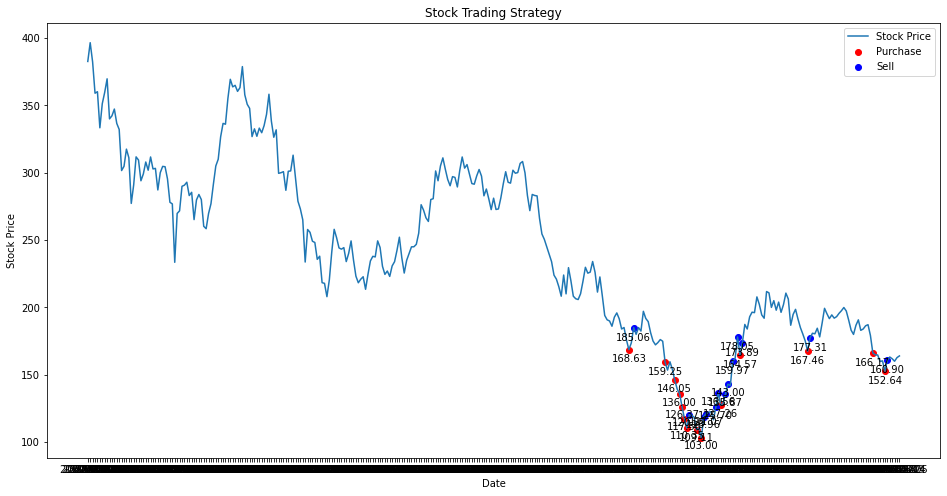

In [389]:
plot_trading_strategy(df_TSLA_stock, result)

In [391]:
to_check = []
for e1 in [.03, .05, .07, .1, .12, .15]:
    for e2 in [.03, .05, .07, .1, .12, .15]:
        for m in [1,1.05]:
            result = stock_trading_strategy(df_TSLA_stock, '2022-11-22', '2023-05-03',10000, 1000, buy_threshold=e1, sell_threshold=e2, multiplier=m)
            to_check.append((e1, e2, m, ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000), (result['total_stock_value']+result['total_cash']).min() - 10000))
for better in sorted(
    to_check, 
    key=lambda x: x[3],
    reverse=True
)[:10]:
    print(better)


(0.03, 0.15, 1.05, 2326.295379152418, -1628.0994490307512)
(0.05, 0.15, 1.05, 2058.030140106697, -1210.614430712587)
(0.03, 0.15, 1, 1946.7268647583405, -1443.7401405472865)
(0.03, 0.12, 1.05, 1859.3065589704765, -1628.0994490307512)
(0.05, 0.15, 1, 1774.5229607071597, -1096.858451723292)
(0.03, 0.1, 1.05, 1695.93233421695, -1628.0994490307512)
(0.05, 0.12, 1.05, 1680.178295153455, -1210.614430712587)
(0.03, 0.03, 1.05, 1634.6862373118183, -1523.374257028585)
(0.05, 0.1, 1.05, 1615.7084993762346, -1210.614430712587)
(0.05, 0.07, 1.05, 1570.9981317615584, -1152.236127116892)


In [406]:
!pip install yfinance

     |████████████████████████████████| 60 kB 4.3 MB/s            
     |████████████████████████████████| 60 kB 9.4 MB/s             
     |████████████████████████████████| 60 kB 13.1 MB/s            
     |████████████████████████████████| 60 kB 9.5 MB/s             
     |████████████████████████████████| 59 kB 6.0 MB/s             
     |████████████████████████████████| 59 kB 7.1 MB/s             
     |████████████████████████████████| 59 kB 4.7 MB/s             
     |████████████████████████████████| 59 kB 9.6 MB/s             
     |████████████████████████████████| 59 kB 10.1 MB/s            
     |████████████████████████████████| 55 kB 8.3 MB/s             
     |████████████████████████████████| 55 kB 5.7 MB/s             
     |████████████████████████████████| 55 kB 7.2 MB/s             
     |████████████████████████████████| 55 kB 7.5 MB/s             
     |████████████████████████████████| 51 kB 265 kB/s             
     |████████████████████████████████| 50 kB 7.7

In [414]:
import yfinance as yf

In [416]:
start_date = '2020-01-01'
end_date = '2023-05-07'

# Download historical data from Yahoo Finance for AAPL
data = yf.download('TSLA', start=start_date, end=end_date)

# Extract the daily closing prices and reset the index
prices = data[['Close']].reset_index()

# Rename the columns to match the desired format
prices.columns = ['date', 'daily_price']

# Set the date column as the index
prices.set_index('date', inplace=True)

# Ensure daily_price is non-negative
prices['daily_price'] = prices['daily_price'].clip(lower=0)

# Print the resulting dataframe
print(prices.head())

KeyboardInterrupt: 

In [412]:
data[['Close']].reset_index()

,Date,Close
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501
...,...,...
837,2023-05-01,169.589996
838,2023-05-02,168.539993
839,2023-05-03,167.449997
840,2023-05-04,165.789993
